## System steup

In [1]:
from moleculekit.molecule import Molecule
import os
import importlib
from torchmdexp.metrics.rmsd import rmsd
from torchmdexp.metrics.l2_rmsd import l2_rmsd
from torchmdexp.metrics.log_rmsd import log_rmsd
from torchmdexp.metrics.tmscore import tm_score
from torchmdexp.samplers.utils import get_native_coords, get_embeddings
from moleculekit.projections.metricrmsd import MetricRmsd
from moleculekit.projections.metrictmscore import MetricTMscore
import numpy as np
import torch

device = "cuda:1"
precision = torch.float

In [2]:
domain = '1ENH'
ref_pdb = f'/workspace7/torchmd-AD/crystals_dataset/crystals_short_64/level_1/ground_truth/{domain}.pdb'
ref_psf = f'/workspace7/torchmd-AD/crystals_dataset/topology_data/{domain}.psf'
#ref_xtc =  f'/workspace7/torchmd-AD/carles_cath/9b_good_xtc/{domain}_8kcenters.xtc'
#mol = Molecule(ref_xtc)
ref_mol = Molecule(ref_pdb)
ref_mol.filter('name CA')

mol = ref_mol
#mol.read(ref_psf)
ref_mol.read(ref_psf)

In [3]:
mol.resname
length = len(mol.resname)
length

54

In [4]:
#for i in range(length-1):
#    print(np.sqrt(np.square(mol.coords[i] - mol.coords[i+1]).sum()))

In [5]:
#mol.read(ref_xtc)

In [16]:
for i in range(32):
    mol = Molecule('/shared/carles/repo/torchmd-exp/data/a3d/a3d_ca_top_dih.psf')
    mol.read('/shared/carles/repo/torchmd-exp/data/a3d/a3d_kcenters_32clusters_coords.xtc')
    ref_mol = Molecule('/shared/carles/repo/torchmd-exp/data/a3d/a3d_ca.pdb')

    mol.coords = np.expand_dims(mol.coords[:, : , i], axis=-1)
    mol.box = np.expand_dims(mol.box[:, 0], axis=-1)


    native_coords = get_native_coords(ref_mol, device)
    native_coords = native_coords.type(precision)
    coords = get_native_coords(mol, device)
    coords = coords.type(precision)


    print('Starting rmsd: ', rmsd(coords, native_coords).item())#, 'Starting log_rmsd: ', log_rmsd(coords, native_coords))
    #print('Starting tmscore: ', tm_score(coords, native_coords), 'Starting l2_rmsd: ', l2_rmsd(coords, native_coords))

Starting rmsd:  5.419224262237549
Starting rmsd:  6.56096076965332
Starting rmsd:  8.912055969238281
Starting rmsd:  41.15761947631836
Starting rmsd:  10.920272827148438
Starting rmsd:  4.370209693908691
Starting rmsd:  5.827398300170898
Starting rmsd:  27.12180519104004
Starting rmsd:  4.061878204345703
Starting rmsd:  7.210869312286377
Starting rmsd:  2.9772276878356934
Starting rmsd:  8.139520645141602
Starting rmsd:  5.7033915519714355
Starting rmsd:  5.139762878417969
Starting rmsd:  4.1286468505859375
Starting rmsd:  8.442771911621094
Starting rmsd:  10.471351623535156
Starting rmsd:  7.8522138595581055
Starting rmsd:  11.565497398376465
Starting rmsd:  5.247818946838379
Starting rmsd:  7.9331374168396
Starting rmsd:  14.284526824951172
Starting rmsd:  5.72441291809082
Starting rmsd:  3.246816635131836
Starting rmsd:  7.526526927947998
Starting rmsd:  6.5091776847839355
Starting rmsd:  9.960436820983887
Starting rmsd:  4.721212863922119
Starting rmsd:  13.05184555053711
Starting 

In [22]:
# Compute starting coords
#[mol.dropFrames(1) for _ in range(32)]

mol.coords = np.expand_dims(mol.coords[:, : , 1], axis=-1)
mol.box = np.expand_dims(mol.box[:, 0], axis=-1)


native_coords = get_native_coords(ref_mol, device)
native_coords = native_coords.type(precision)
coords = get_native_coords(mol, device)
coords = coords.type(precision)


print('Starting rmsd: ', rmsd(coords, native_coords), 'Starting log_rmsd: ', log_rmsd(coords, native_coords))
print('Starting tmscore: ', tm_score(coords, native_coords), 'Starting l2_rmsd: ', l2_rmsd(coords, native_coords))


IndexError: index 1 is out of bounds for axis 2 with size 1

In [23]:
print(0.5-rmsd(coords, native_coords))

tensor(-5.9969, device='cuda:1')


In [24]:
tm_score(coords, native_coords)

tensor(0.3158, device='cuda:1')

In [25]:
from torchmd.forcefields.forcefield import ForceField
from torchmd.parameters import Parameters


ff = ForceField.create(mol, '/shared/carles/repo/torchmd-exp/data/ca_priors-dihedrals_general.yaml')
parameters = Parameters(ff, mol, precision=precision, device=device)

In [26]:
from torchmd.integrator import maxwell_boltzmann
from torchmd.systems import System

system = System(mol.numAtoms, nreplicas=1, precision=precision, device=device)
system.set_positions(mol.coords)
system.set_box(mol.box)
system.set_velocities(maxwell_boltzmann(parameters.masses, T=350, replicas=1))




In [27]:
system.pos.shape

torch.Size([1, 73, 3])

In [28]:
if torch.any(torch.isnan(system.pos)):
    raise RuntimeError("Found NaN coordinates.")

In [29]:
get_embeddings(mol, 'cpu', 1)

tensor([[15,  2, 12,  7,  1,  6,  3, 19, 10, 18, 20,  1,  1, 21, 19, 13, 18, 20,
         10,  1, 20,  2,  2, 12,  6,  1,  6, 20,  1,  1,  3,  6, 19,  6, 21,  1,
          1,  3,  6, 12,  6, 20, 10,  1,  4, 19,  2, 19,  2,  9,  8,  6, 14,  6,
          1, 20, 18, 19,  6,  1,  1,  1, 21, 18,  5,  6, 20, 10,  1,  4, 18, 11,
          9]])

In [60]:
externalmodule = importlib.import_module('torchmdnet.calculators')
nnp = '/shared/carles/torchmd-exp/scripts/trainings/tests/test_crystals/crystals_256_levels/no_priors/tm09_cut12_lay4_b16_lev32_lr1e-3_lrd08_clip03_l2_loss'
nnp += '/epoch=154-train_loss=0.0503-val_loss=0.9022.ckpt'
#nnp = '/workspace2/fast_folders_cgnet/multiprotein/M-test-fixed/NNP_torchMD2_moreHomeo/train_geom_multi_dih_4int_fix_homeo_rep2/'
#nnp += 'epoch=97-val_loss=719.2455-test_loss=21.2833.ckpt'
embeddings = torch.tensor([ 4,  4,  5,  8,  6, 13,  2, 13,  7,  4]).repeat(1, 1)
external = externalmodule.External(nnp, embeddings, device)

In [61]:
print('Number of parameters nnp: ', sum(p.numel() for p in external.model.parameters() if p.requires_grad))

Number of parameters nnp:  294565


In [62]:
from torchmd.forces import Forces
#external=None
priors = ['bonds', 'repulsioncg', 'dihedrals']
forces = Forces(parameters,terms=priors, cutoff=9, rfa=False, switch_dist=None, 
                external=external, exclusions = ('bonds')
               )
# Evaluate current energy and forces. Forces are modified in-place
Epot = forces.compute(system.pos, system.box, system.forces, returnDetails=False)
print(Epot)
print(system.forces)

[39.332509994506836]
tensor([[[  2.1660,   4.0122,   5.6670],
         [ -2.7828,   3.9588,  -3.6668],
         [ 15.8696, -13.1288,   0.4036],
         [ -0.2686,  -1.6710,   0.2314],
         [  5.0042,  15.8164,  10.7844],
         [ -8.0190,  -4.7895, -11.7194],
         [-14.8880,  -1.6529,  -0.5162],
         [  9.9312,  -1.6082,  15.8392],
         [-14.8887,  -0.8721, -11.8227],
         [  7.8761,  -0.0650,  -5.2003]]], device='cuda:1')


## Dynamics

In [63]:
from torchmd.integrator import Integrator
from torchmd.wrapper import Wrapper

langevin_temperature = 350  # K
langevin_gamma = 1
timestep = 5  # fs

integrator = Integrator(system, forces, timestep, device, gamma=langevin_gamma, T=langevin_temperature)
wrapper = Wrapper(mol.numAtoms, mol.bonds if len(mol.bonds) else None, device)


In [64]:

def minimize_bfgs(system, forces, fmax=0.05, steps=1000):
    from scipy.optimize import minimize

    if steps == 0:
        print(
                "{0:4d}   {1: 3.6f}   {2: 3.6f}".format(
                    info["Nfeval"], Epot, np.max(np.linalg.norm(grad, axis=1))))
        return

    if system.pos.shape[0] != 1:
        raise RuntimeError(
            "System minimization currently doesn't support replicas. Talk with Stefan to implement it."
        )

    def evalfunc(coords, info):
        coords = coords.reshape(1, -1, 3)
        coords = torch.tensor(coords).type_as(system.pos)
        Epot = forces.compute(coords, system.box, system.forces)[0]
        grad = -system.forces.detach().cpu().numpy().astype(np.float64)[0]
        # display information
        #if info["Nfeval"] % 1 == 0:
            #print(
            #    "{0:4d}   {1: 3.6f}   {2: 3.6f}".format(
            #        info["Nfeval"], Epot, np.max(np.linalg.norm(grad, axis=1))
            #    )
            #)
        #info["Nfeval"] += 1
        return Epot, grad.reshape(-1)

    #print("{0:4s} {1:9s}       {2:9s}".format("Iter", " Epot", " fmax"))
    x0 = system.pos.detach().cpu().numpy()[0].astype(np.float64)

    res = minimize(
        evalfunc,
        x0,
        method="L-BFGS-B",
        jac=True,
        options={"gtol": fmax, "maxiter": steps, "disp": False},
        args=({"Nfeval": 0},),
    )

    system.pos = torch.tensor(
        res.x.reshape(1, -1, 3),
        dtype=system.pos.dtype,
        device=system.pos.device,
        requires_grad=system.pos.requires_grad,
    )

In [65]:
#from torchmd.minimizers import minimize_bfgs, minimize_pytorch_bfgs

print(rmsd(system.pos, native_coords))
print(minimize_bfgs(system, forces, steps=20000))  # Minimize the system
print(rmsd(system.pos, native_coords))

tensor(1.9902, device='cuda:1')
None
tensor(2.1660, device='cuda:1')


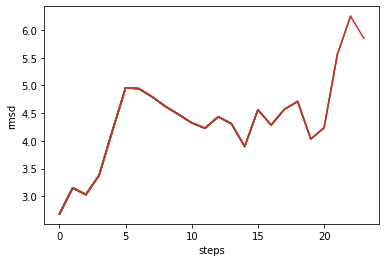

  2%|▊                                  | 24/1000 [01:16<51:46,  3.18s/it]


KeyboardInterrupt: 

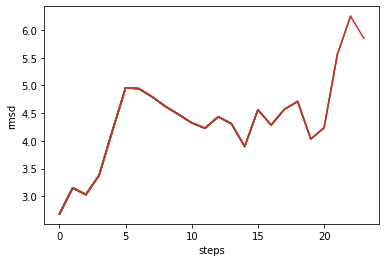

In [66]:
from tqdm import tqdm 
import numpy as np
%matplotlib inline
import time
import pylab as pl
from IPython import display

FS2NS = 1E-6 # Femtosecond to nanosecond conversion

steps = 100000
output_period = 100
save_period = 10
traj = []

trajectoryout = "mytrajectory.npy"

iterator = tqdm(range(1, int(steps / output_period) + 1))
Epot = forces.compute(system.pos, system.box, system.forces)
rmsds = []
Ep = []
Et = []
tm_scores = []
for i in iterator:
    Ekin, Epot, T = integrator.step(niter=output_period)
    rmsds.append(rmsd(system.pos, native_coords).item())
    tm_scores.append(tm_score(system.pos, native_coords).item())
    Ep.append(Epot)
    Et.append(Ekin + Epot)
    pl.plot(rmsds)
    pl.xlabel('steps')
    pl.ylabel('rmsd')
    
    display.clear_output(wait=True)
    display.display(pl.gcf())

In [ ]:
#print(rmsds)

In [70]:
#print(tm_scores)

In [57]:
#pos_xtc = start_pos.detach().cpu().numpy().copy()
#mol.coords = np.moveaxis(pos_xtc, 0, -1)
#mol.write(f'/workspace7/torchmd-AD/carles_cath/9b_good_xtc/{domain}.pdb')

In [58]:
#mol.box = np.array([39.972, 39.941, 39.935], dtype=np.float32)

Text(0, 0.5, 'rmsd')

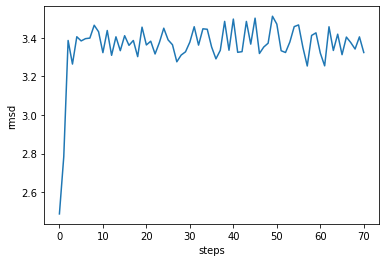

In [21]:
pl.plot(rmsds)
pl.xlabel('steps')
pl.ylabel('rmsd')

Text(0, 0.5, 'E')

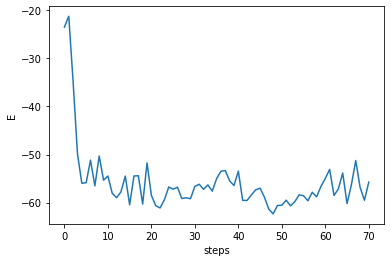

In [22]:
pl.plot(Ep)
pl.xlabel('steps')
pl.ylabel('E')

Text(0, 0.5, 'E')

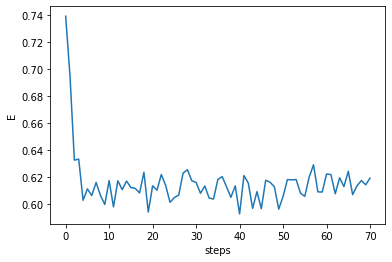

In [23]:
pl.plot(tm_scores)
pl.xlabel('steps')
pl.ylabel('E')

Text(0, 0.5, 'E')

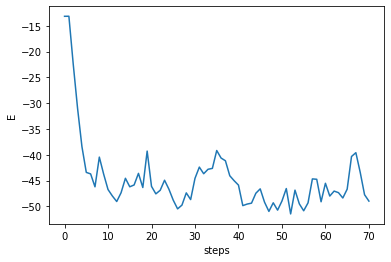

In [24]:
pl.plot(Et)
pl.xlabel('steps')
pl.ylabel('E')

In [67]:
max(1,2)

2

In [68]:
import torch

In [78]:
torch.max(torch.tensor(0.0), torch.tensor(2.0) - 1.0)

tensor(1.)